⏳ Checking and installing dependencies for Colab...
✅ Dependencies installed/verified.

Step 1: Generating 1000 synthetic patient records...
Step 2: Preprocessing data...
Step 3: Training models (XGBoost, LightGBM, CatBoost)...

--- Model Performance ---
XGBoost -> Accuracy: 0.7600 | AUC: 0.7504
LightGBM -> Accuracy: 0.7450 | AUC: 0.7313
CatBoost -> Accuracy: 0.7700 | AUC: 0.7583

🏆 Best Model Selected: CatBoost (Accuracy: 0.7700)

--- Sample Predictions (0=Healthy, 1=Disease) ---
Predicted: [1 0 1 0 1 0 1 1 0 0 0 1 0 1 1]
Actual:    [1 0 1 0 1 1 0 0 0 0 1 1 0 0 1]

--- Generating Confusion Matrix Plot ---


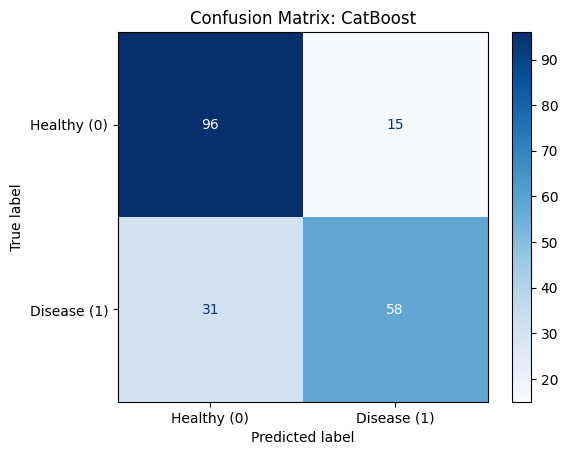

Step 4: Generating SHAP explanations for CatBoost...


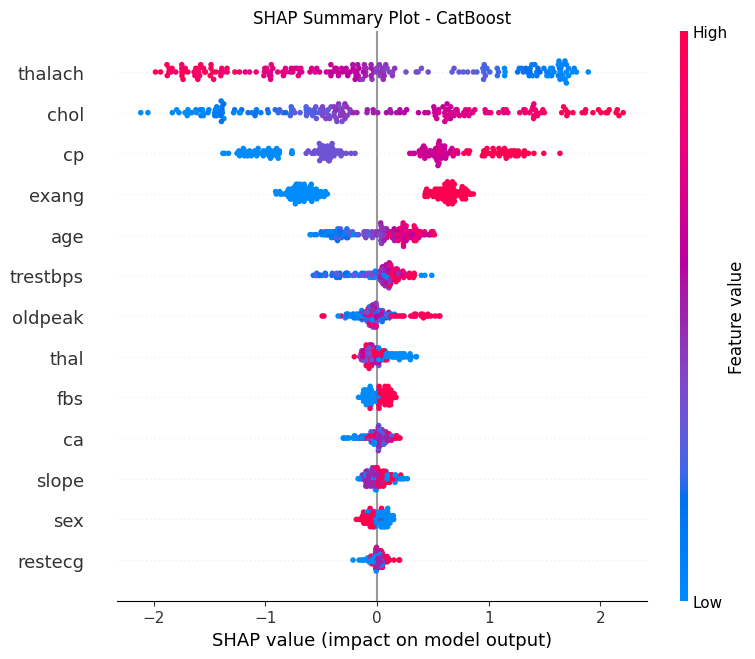

✅ SHAP Summary Plot generated.

🚀 Execution Complete.
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang   oldpeak  \
0     67    0   0       134   370    0        1      162      1  3.125624   
1     57    1   1        99   558    1        0      135      0  2.001421   
2     43    0   1       118   317    0        0      117      0  1.600267   
3     71    1   3       106   443    1        0      176      0  2.876710   
4     36    0   2       191   231    0        0      200      0  0.826362   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...       ...   
995   34    1   1       113   209    1        1       76      0  0.496393   
996   54    1   0       190   524    0        2      154      1  2.941610   
997   32    0   3       183   367    0        1      123      1  0.061809   
998   47    1   2       132   241    1        2      177      0  0.525550   
999   48    1   2       178   234    1        0      171      0  5.007280   

     slope  ca  thal 

In [2]:
import subprocess
import sys

def install_packages():
    """
    Automatically installs necessary packages in Google Colab environment.
    """
    packages = ['catboost', 'shap', 'xgboost', 'lightgbm']
    print("⏳ Checking and installing dependencies for Colab...")
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    print("✅ Dependencies installed/verified.\n")

# Run installation first
install_packages()

# --- MAIN PIPELINE CODE ---
import pandas as pd
import numpy as np
import warnings
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Import models after installation
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import shap

warnings.filterwarnings('ignore')

class HeartDiseasePipeline:
    def __init__(self):
        self.models = {}
        self.best_model = None
        self.best_model_name = ""
        self.scaler = StandardScaler()
        self.encoders = {}

    def generate_synthetic_data(self, n_samples=1000):
        print(f"Step 1: Generating {n_samples} synthetic patient records...")
        np.random.seed(42)

        data = pd.DataFrame({
            'age': np.random.randint(29, 77, n_samples),
            'sex': np.random.choice([0, 1], n_samples),
            'cp': np.random.choice([0, 1, 2, 3], n_samples),
            'trestbps': np.random.randint(94, 200, n_samples),
            'chol': np.random.randint(126, 564, n_samples),
            'fbs': np.random.choice([0, 1], n_samples),
            'restecg': np.random.choice([0, 1, 2], n_samples),
            'thalach': np.random.randint(71, 202, n_samples),
            'exang': np.random.choice([0, 1], n_samples),
            'oldpeak': np.random.uniform(0, 6.2, n_samples),
            'slope': np.random.choice([0, 1, 2], n_samples),
            'ca': np.random.choice([0, 1, 2, 3, 4], n_samples),
            'thal': np.random.choice([0, 1, 2, 3], n_samples),
        })

        # Synthetic logic for target
        logits = (data['age'] * 0.02 + data['chol'] * 0.005 - data['thalach'] * 0.02 +
                  data['cp'] * 0.5 + data['exang'] * 0.8 + np.random.normal(0, 1, n_samples))
        data['target'] = (logits > 1.5).astype(int)
        return data

    def preprocess(self, df):
        print("Step 2: Preprocessing data...")
        X = df.drop('target', axis=1)
        y = df['target']

        cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
        num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

        X[num_cols] = self.scaler.fit_transform(X[num_cols])

        for col in cat_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            self.encoders[col] = le

        return train_test_split(X, y, test_size=0.2, random_state=42)

    def train_evaluate(self, X_train, X_test, y_train, y_test):
        print("Step 3: Training models (XGBoost, LightGBM, CatBoost)...")

        xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        xgb_model.fit(X_train, y_train)
        self.models['XGBoost'] = xgb_model

        lgb_model = lgb.LGBMClassifier(verbosity=-1, random_state=42)
        lgb_model.fit(X_train, y_train)
        self.models['LightGBM'] = lgb_model

        cat_model = CatBoostClassifier(verbose=0, random_state=42)
        cat_model.fit(X_train, y_train)
        self.models['CatBoost'] = cat_model

        best_score = 0
        print("\n--- Model Performance ---")
        for name, model in self.models.items():
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            auc = roc_auc_score(y_test, preds)
            print(f"{name} -> Accuracy: {acc:.4f} | AUC: {auc:.4f}")

            if acc > best_score:
                best_score = acc
                self.best_model = model
                self.best_model_name = name

        print(f"\n🏆 Best Model Selected: {self.best_model_name} (Accuracy: {best_score:.4f})")

        # --- NEW: Output 0 and 1 predictions explicitly ---
        best_preds = self.best_model.predict(X_test)
        print("\n--- Sample Predictions (0=Healthy, 1=Disease) ---")
        print(f"Predicted: {best_preds[:15]}")
        print(f"Actual:    {y_test[:15].values}")

        # --- NEW: Plot Confusion Matrix ---
        print("\n--- Generating Confusion Matrix Plot ---")
        cm = confusion_matrix(y_test, best_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy (0)', 'Disease (1)'])
        disp.plot(cmap='Blues')
        plt.title(f"Confusion Matrix: {self.best_model_name}")
        plt.show() # Shows the plot in Colab

        return X_test

    def explain_model(self, X_test):
        print(f"Step 4: Generating SHAP explanations for {self.best_model_name}...")

        shap.initjs()
        explainer = shap.TreeExplainer(self.best_model)
        shap_values = explainer.shap_values(X_test)

        if isinstance(shap_values, list):
            shap_values = shap_values[1]

        # Display plot inline for Colab
        plt.figure()
        plt.title(f"SHAP Summary Plot - {self.best_model_name}")

        # This plot shows how features push the output towards 0 or 1
        shap.summary_plot(shap_values, X_test, show=True)
        print("✅ SHAP Summary Plot generated.")

if __name__ == "__main__":
    pipeline = HeartDiseasePipeline()
    raw_data = pipeline.generate_synthetic_data()
    X_train, X_test, y_train, y_test = pipeline.preprocess(raw_data)
    X_test_processed = pipeline.train_evaluate(X_train, X_test, y_train, y_test)
    pipeline.explain_model(X_test_processed)
    print("\n🚀 Execution Complete.")
    print(raw_data)